# Getting Started with TSPulse Zero-Shot Imputation

This notebook demonstrates the usage of a pre-trained `TSPulse` model for time-series `imputation` task in a `zero-shot setting`. Refer to [TSPulse](https://arxiv.org/abs/2505.13033) paper for architecture and other details.

In zero-shot setting a pre-trained TSPulse model with all the weights frozen is used and a quick inference call can be made by passing the input data (possibly having missing values) and the pre-trained model to the `time series imputation pipeline`, which returns an output with the missing values imputed by the model.

The pre-trained TSPulse model can be accessed from the [Hugging Face TSPulse Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-tspulse-r1).

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from ipywidgets import IntSlider, interact
from transformers import set_seed

In [2]:
from tsfm_public import TimeSeriesPreprocessor
from tsfm_public.models.tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.time_series_imputation_pipeline import TimeSeriesImputationPipeline

## Preparing the Dataset

In [3]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 0

TARGET_DATASET = "etth1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

In [4]:
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.
target_columns = [
    "HUFL",
    "HULL",
    "MUFL",
    "MULL",
    "LUFL",
    "LULL",
    "OT",
]  # mention the target column names in the dataset that should be imputed by the model

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

fully_observed_data = data.copy()

print(data.shape)
print(data.head())

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

(17420, 8)
                 date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0 2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1 2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2 2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3 2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4 2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


### Introducing NaN values to the dataset to mimic real world missing data
We are introducing missing values in a hybrid setup i.e. both isolated points missing as well as points missing in continuous blocks of a fixed length (here 8) which is a typical real-world scenario for missing data.

In [5]:
def introduce_nans(data, nan_fraction=0.1, block_size=8, seed=42):
    df_nan = data.copy()
    num_values = df_nan.shape[0] * len(target_columns)
    num_nans = int((nan_fraction * num_values) / 1.5)  # 2/3 of the missing values are randomly missing values
    print("num_nans : ", num_nans)
    rows = np.random.randint(0, df_nan.shape[0], size=num_nans)
    cols = np.random.randint(1, len(target_columns), size=num_nans)

    for r, col in zip(rows, cols):
        df_nan.iat[r, col] = np.nan

    n_rows, n_cols = df_nan.shape
    rng = np.random.default_rng(seed)

    num_blocks = int((num_nans / block_size) * (1 / 3))  # half of the missing values are missing in blocks
    print("num_blocks : ", num_blocks)
    for _ in range(num_blocks):
        col = rng.integers(1, n_cols)
        start_row = rng.integers(n_rows - block_size + 1)
        df_nan.iloc[start_row : start_row + block_size, col] = np.nan

    return df_nan

In [6]:
data = introduce_nans(data, nan_fraction=0.2)
data.head(100)

num_nans :  16258
num_blocks :  677


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,NaN,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,NaN,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
95,2016-07-04 23:00:00,NaN,6.497,NaN,3.482,3.168,1.980,25.466000
96,2016-07-05 00:00:00,NaN,5.626,8.777,2.949,3.198,1.980,25.958000
97,2016-07-05 01:00:00,NaN,6.296,8.955,3.163,NaN,2.010,25.958000
98,2016-07-05 02:00:00,NaN,6.296,8.813,3.376,2.985,1.919,26.028000


### Creating a tsp (To preprocess the input data and perform scaling (if needed))

In [7]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

## Getting the pre-trained TSPulse Model

In [8]:
model = TSPulseForReconstruction.from_pretrained(
    "ibm-granite/granite-timeseries-tspulse-r1",
    revision="tspulse-hybrid-dualhead-512-p8-r1",
    num_input_channels=tsp.num_input_channels,
    mask_type="user",
)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

## Using Imputation Pipeline for Zero-Shot Imputation

In [9]:
tsp.train(data)  # train the tsp
pipe = TimeSeriesImputationPipeline(model, feature_extractor=tsp, batch_size=1000, device=device)

Device set to use cuda


In [10]:
out = pipe(data)

In [11]:
out.shape

(17420, 15)

In [12]:
out.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT,HUFL_imputed,HULL_imputed,MUFL_imputed,MULL_imputed,LUFL_imputed,LULL_imputed,OT_imputed
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000,5.827,2.009,1.599000,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,NaN,0.426,4.142,1.371,27.787001,5.693,2.076,2.391272,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,NaN,0.355,3.777,1.218,27.787001,5.157,1.741,2.150796,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001,5.090,1.942,1.279000,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000,5.358,1.942,1.492000,0.462,3.868,1.279,21.948000


## Plotting the Observed and Imputed values

In [13]:
def plot_interactive_imputation(df, window_size=512):
    df = df.drop("date", axis=1)
    observed_cols = [col.removesuffix("_imputed") for col in df.columns if col.endswith("_imputed")]

    num_points = len(df)

    def plot_window(start_idx):
        end_idx = min(start_idx + window_size, num_points)
        x_range = np.arange(start_idx, end_idx)

        plt.figure(figsize=(15, 3 * len(observed_cols)))

        for i, base_col in enumerate(observed_cols):
            imputed_col = f"{base_col}_imputed"
            observed_vals = df[base_col].iloc[start_idx:end_idx]
            imputed_vals = df[imputed_col].iloc[start_idx:end_idx]

            pos_observed = ~observed_vals.isna()
            pos_imputed = observed_vals.isna()

            plt.subplot(len(observed_cols), 1, i + 1)
            plt.plot(x_range[pos_observed], observed_vals[pos_observed], color="blue", linewidth=2, label="Observed")
            plt.scatter(x_range[pos_imputed], imputed_vals[pos_imputed], color="red", s=5, label="Imputed")
            plt.title(f"Channel: {base_col}")
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

    print("Plotting static plot for first window")
    plot_window(0)  # plotting the first window as static plot

    interact(
        plot_window,
        start_idx=IntSlider(
            value=0,
            min=0,
            max=max(0, num_points - window_size),
            step=1,
            description="Start Index",
            continuous_update=False,
        ),
    )

Plotting static plot for first window


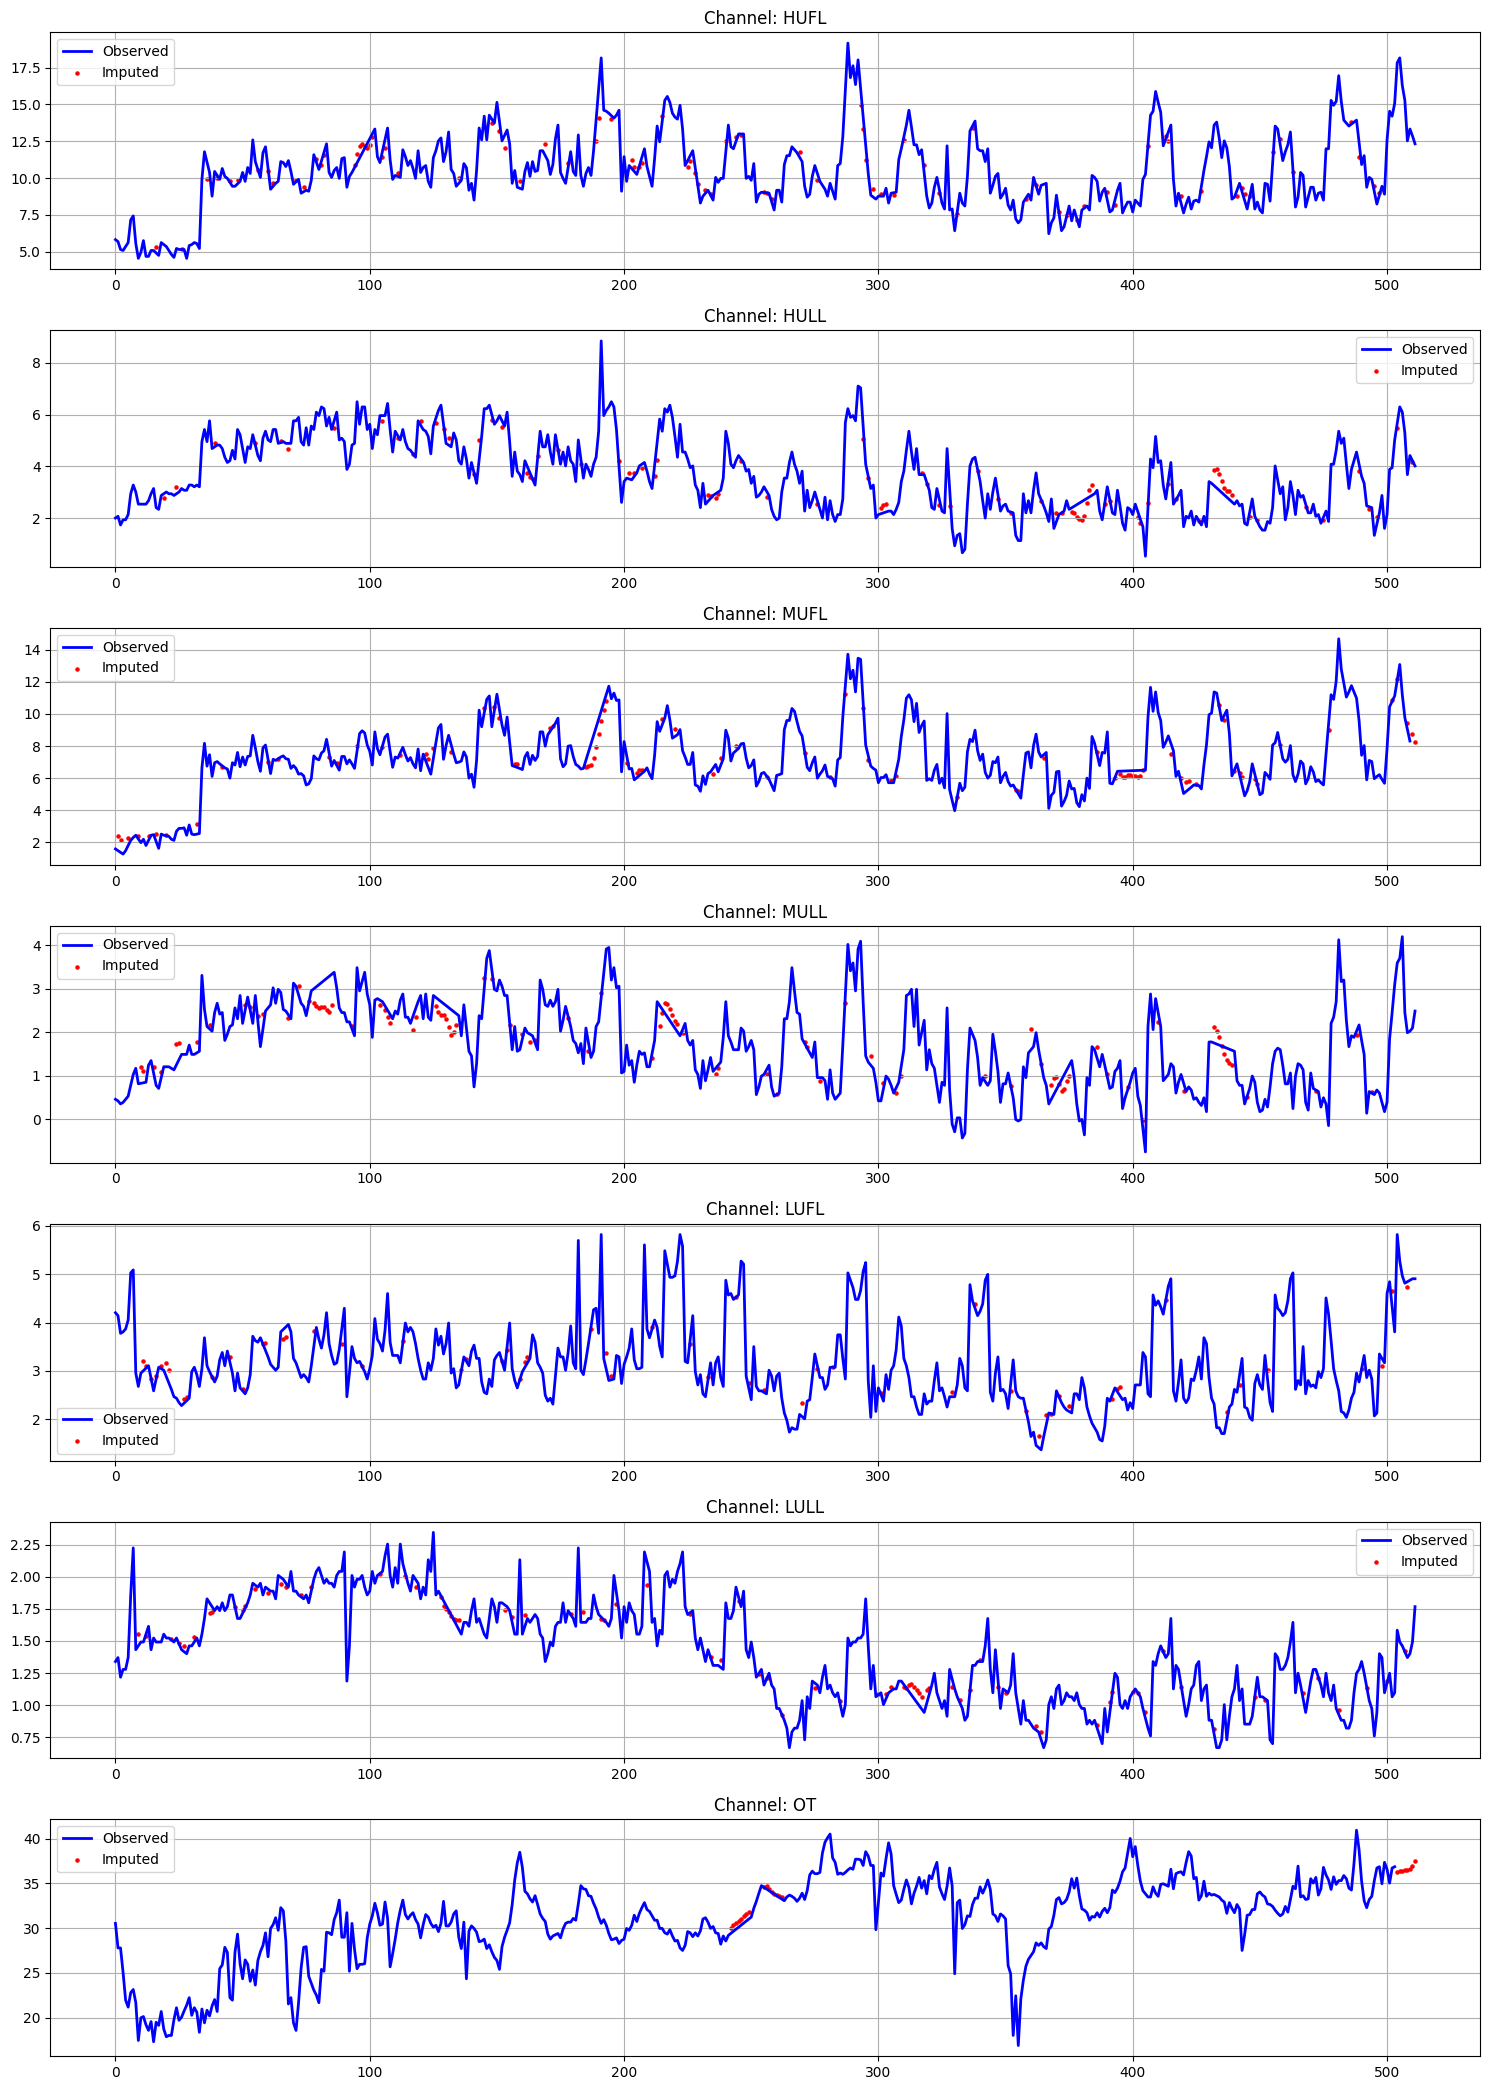

interactive(children=(IntSlider(value=0, continuous_update=False, description='Start Index', max=16908), Outpu…

In [14]:
plot_interactive_imputation(out)

## Evaluate the Model

Evaluate the zero-shot performance of the model on the dataset.

In [15]:
def custom_metric(actual, missing_df, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = actual.to_numpy(dtype=float)
    p = prediction.to_numpy(dtype=float)

    missing_positions = np.isnan(missing_df)

    mse = np.mean(np.square(a[missing_positions] - p[missing_positions]))
    mae = np.mean(np.abs(a[missing_positions] - p[missing_positions]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )

In [16]:
ground_truth = fully_observed_data[target_columns]  # original df having no missing values
ground_truth_with_missing_data = out[target_columns]  # df having missing values

imputed_columns = [f"{col}_imputed" for col in target_columns]
imputed_df = out[imputed_columns]  # df having imputed values at the missing data positions

custom_metric(ground_truth, ground_truth_with_missing_data, imputed_df, "zero-shot imputation")

,zero-shot imputation
mean_squared_error,1.656264
root_mean_squared_error,1.286959
mean_absolute_error,0.686654
